پروژه : طراحی مدل ساده تولید متن

تعداد لایه های مدل : 6 لایه

لایه های به کار رفته در مدل : ترنسفورمر , خطی , نرمالیزیشن


توکنایزر :  توکنایزر کاراکتری  

طراحی توکنایزر : دستی

دیتاست : یک پاراگراف کوتاه انگلیسی

منابع مورد نیاز برای اجرای همین کد: cpu

توجه : میتوانید یک دیتاست بزرگ  و یک توکنایزر کلمه ای برای آموزش مدل استفاده کنید.در این تکه کد تمرکز بر ساختار مدل است

دارید GPU در صورت تغییر دیتاست و توکنایزر احتمالا نیاز به



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

In [ ]:
# Tiny English Dataset
text = """The quick brown fox jumps over the lazy dog.
Alice was beginnig to get very tired of sitting by her sister on the bank.
Call me Ishmael.It was the best of times, it was the worst of times."""
text *= 200

##### __Char-Level Tokenizer :__

در این کد از توکنایزر کاراکتری استفاده کردیم. اما چرا ؟

##### 1. توکنایزر کاراکتری را میشه همین جا و در لحظه ساخت


##### 2. مناسب دیتاست کوچک است
 توکنایزر کلمه ای معمولا نیاز به واژگان زیاد مثلا 30 هزار توکن دارد

##### 3. out of vocabulary جلوگیری از مشکل
 UNK در مدل های کلمه ای اگه کلمه جدید باشه, میره به دسته

در کاراکتری چنین مشکلی نیست.هر کاراکتر رو جدا یاد میگیره,حتی اگر کلمه کاملا جدید باشه

##### **نقطه ضعف توکنایزر کاراکتری**

مدل باید توالی های طولانی تری را ببیند تا مفهوم کلمه و جمله را بفهمد, چون کلمات را مستقیم نمیشناسه

برای متن واقعی بزرگ, این روش از نظر کارایی ضعیف است

ولی برای یک مدل تمرینی کوچک, مزایای سادگی و اجراپذیری خیلی بیشتره

 و یک دیتاست بزرگ نوشت subword میتوان همین مدل را با توکنایزر کلمه ای یا


In [ ]:
# Char-Level Tokenizer
chars = sorted(set(text))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}
encode = lambda s:[stoi[c] for c in s]
decode = lambda I:"".join(itos[i] for i in I)
data = torch.tensor(encode(text),dtype=torch.long)

In [ ]:
# Train/Val split
n = int(0.9 * len(data))
train_data , val_data = data[:n],data[n:]

In [ ]:
# Model Config
vocab_size = len(chars)
seq_len = 64
n_embd = 128
n_head = 4
n_layer = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### __1.Scaled Dot Product Attention__

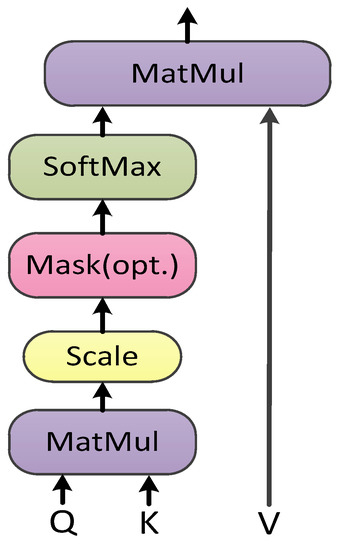

In [ ]:
# scaled Dot product attention
class Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.key = nn.Linear(n_embd , n_embd // n_head , bias = False)
    self.query = nn.Linear(n_embd , n_embd // n_head , bias = False)
    self.value = nn.Linear(n_embd , n_embd // n_head , bias = False)
    self.register_buffer('tril' , torch.tril(torch.ones(seq_len , seq_len)))

  def forward(self,x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)
    wei = q @ k.transpose(-2,-1) * (C // n_head) ** 0.5
    wei = wei.masked_fill(self.tril[:T,:T] == 0,float('-inf'))
    wei = F.softmax(wei,dim = -1)
    v = self.value(x)
    out = wei @ v
    return out

### __2.Multi Head Attention__

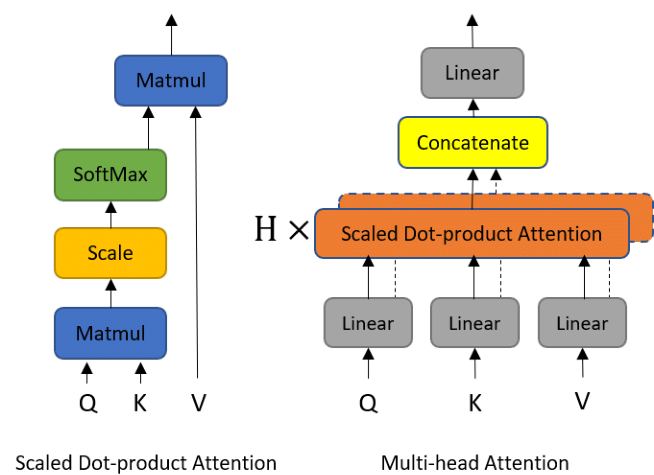

In [ ]:
# MultiHead Attention
class MultiHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.heads = nn.ModuleList([Head() for _ in range(n_head)])
    self.proj = nn.Linear(n_embd , n_embd) # projection

  def forward(self,x):
    out = torch.cat([h(x) for h in self.heads],dim=-1)
    return self.proj(out)

### __3.Feed Forward__

In [ ]:
# FeedForward
class FeedForward(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd,n_embd)
    )

  def forward(self,x):
    return self.net(x)

### __4.Transformer Block__ (Encoder_Only)

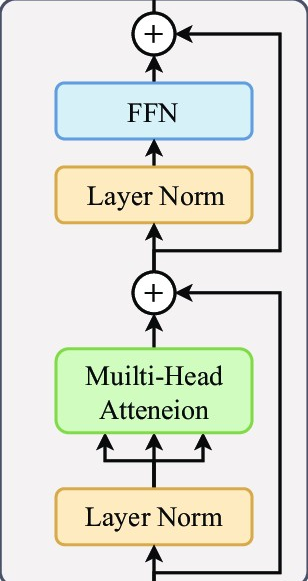

In [ ]:
# Transformer Block ( Encoder_Only )
class Block(nn.Module):
  def __init__(self):
    super().__init__()
    self.sa = MultiHead()    # sa -> self attention
    self.ff = FeedForward()
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self,x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ff(self.ln2(x))
    return x

### __5.دید کلی__


توجه کنید که ترنسفورمر در حالت کلی دو بلاک دیکودر و انکودر دارد.اما ما تنها بلاک انکودر - سمت چپی در عکس پایین - را برابر با بلاک ترنسفورمر گرفتیم

Transformer Block -> **Encoder Block** + Decoder Block

تنها بلاک انکودر را دارند  BERT  بسیاری از مدل های تولید متن مثل

میگویند Encoder_Only اصطلاحا به این مدل ها


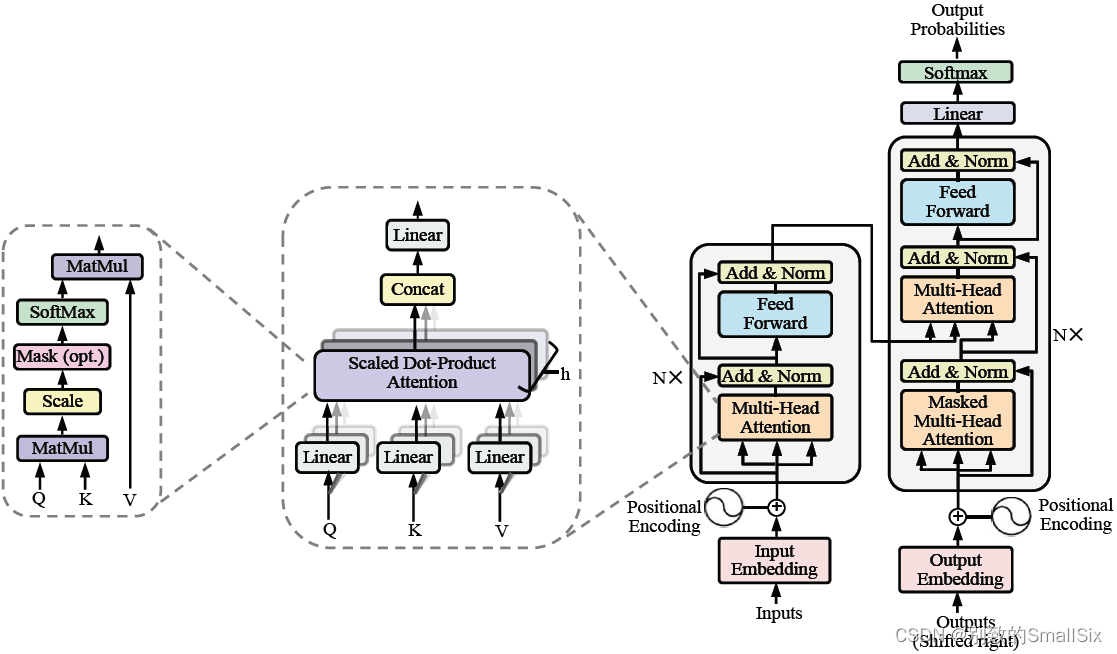

### **6.Full Model**

Full Model :

tok_embd + pos_embd -> 6*[Transformer_Block] -> Normalization -> Linear_layer

**methods :**

init -> تعریف یک شی از کلاس

forward method -> دادن ورودی به شکل مستقیم به شی تعریف شده از کلاس

generate method -> تولید متن با فراخوانی این متد

In [ ]:
class MiniGPT(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_emb = nn.Embedding(vocab_size,n_embd)
    self.pos_emb = nn.Embedding(seq_len,n_embd)
    self.blocks = nn.Sequential(*[Block() for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size)

  def forward(self,idx,targets=None):
    B,T = idx.shape
    tok = self.token_emb(idx)
    pos = self.pos_emb(torch.arange(T,device=device))
    x = tok + pos
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,vocab_size),targets.view(-1))
    return logits , loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-seq_len:]
      logits,_ = self(idx_cond)
      probs = F.softmax(logits[:,-1,:],dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=-1)
    return idx

### **7.Training Loop**

In [ ]:
model = MiniGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)

In [ ]:
def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - seq_len,(32,))
  x = torch.stack([data[i:i+seq_len] for i in ix])
  y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
  return x.to(device),y.to(device)

In [ ]:
for step in range(500):
  xb,yb = get_batch('train')
  _,loss = model(xb,yb)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    print(f"Step {step} Loss {loss.item():.4f}")

Step 0 Loss 3.6128
Step 100 Loss 0.8358
Step 200 Loss 0.2529
Step 300 Loss 0.1310
Step 400 Loss 0.1072


#### Sample Generation

In [ ]:
# Sample Generation
context = torch.zeros((1,1),dtype=torch.long,device=device)
print(decode(model.generate(context,max_new_tokens=200)[0].tolist()))


Alice was beginnig to get very tired of sitting by her sister on the wank.
Call be Ishmael.It was wal best of ory t her d ofog onk e thes, d tis time onk.
Cashe l.The ofox lll.Thmps wnn It f t Is, t w
